(mobility-activity)=
# Estimating Activity through Mobility Data

Less movement typically means less economic activity. Understanding where and when population movement occurs can help inform public policy and disaster response, especially during crises. 

Similarly to [COVID-19 Community Mobility Reports](https://www.google.com/covid19/mobility/), [Facebook Population During Crisis](https://dataforgood.facebook.com/dfg/tools/facebook-population-maps) and [Mapbox Movement Data](https://www.mapbox.com/movement-data), we generate a series of crisis-relevant indicators, including a baseline and ongoing densities (i.e., **n_baseline** and **count**), **percent change** and **z-score**. The indicators are calculated by tallying the device count in each tile and at each time period. The devices are drawn out from longitudinal mobility data. 

It is important to emphasize the significant {ref}`mobility-activity-limitations` of such an approach. In particular, mobility data is primarily collected through convenience sampling and lacks the controlled methodology of randomized trials.

In [1]:
from datetime import datetime

import colorcet as cc
import dask.dataframe as dd
import datashader
import geopandas
import holoviews as hv
import pandas as pd
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    Legend,
    Range1d,
    Span,
    TabPanel,
    Tabs,
    Text,
    Title,
)
from bokeh.plotting import figure, output_notebook, show
from holoviews.element.tiles import CartoDark
from holoviews.operation.datashader import rasterize
from sklearn.preprocessing import StandardScaler

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
from dask.distributed import Client

client = Client(n_workers=4)
client

<Client: 'tcp://127.0.0.1:49650' processes=4 threads=12, memory=64.00 GiB>

## Data

In this section, we import from the data sources, available either publicly or via {ref}`foundational-data`.

In [4]:
# https://papermill.readthedocs.io/en/latest/usage-parameterize.html
PANEL = "v2023.10"

### Area of Interest 

In this step, we import the clipping boundary and the H3 tessellation defined by **area(s) of interest** below. 

In [5]:
AOI = geopandas.read_file("../../data/final/tessellation/SYRTUR_tessellation.gpkg")

AOI[["geometry", "hex_id", "distance_bin", "distance"]].explore(
    column="distance_bin",
    cmap="seismic_r",
    style_kwds={"stroke": True, "fillOpacity": 0.05},
)

```{figure} ../../docs/images/logo.png
---
height: 0px
---
Visualization of the area of interest centered at the earthquake's epicenter. The distance (in Km) to the epicenter is calculated for each on H3 (resolution 6) tile.  
```

### Mobility Data

The WB Data Lab team obtained longitudinal human mobility data. The data consisted of anonymized timestamped geographical points generated by GPS-enabled devices, located in Türkiye and Syria and spanning the period shown below.

The project team obtained longitudinal mobility data. We use the mobile location data to compute a baseline and ongoing densities (i.e., **n_baseline** and **count**), **percent change** and **z-score**. The indicators are calculated by tallying the device count in each tile and at each time period. The devices are drawn out from longitudinal mobility data. For additional information, please see {ref}`mobility-data` and {ref}`mobility-activity-methodology`.

In [6]:
ddf = dd.read_parquet(
    f"../../data/final/panels/{PANEL}",
    columns=["hex_id", "longitude", "latitude", "datetime", "uid", "month"],
)

In [7]:
ddf = ddf[ddf["datetime"] >= "2022-07-01"]

```{note}
Due to the data volume and velocity (updated daily), the **panel**'s computation from the raw mobility data took place on AWS. The resulting named dataset above is available on the project's folder.
```

First, we calculate the cardinality, 

In [8]:
len(ddf)

369077444

Now, we calculate the temporal extent, 

In [9]:
print(
    "From",
    ddf["datetime"].min().compute().strftime("%b %d, %Y"),
    "to",
    ddf["datetime"].max().compute().strftime("%b %d, %Y"),
)

From Jul 01, 2022 to Nov 01, 2023


And visualize the mobility data panel's spatial density.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
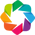

:DynamicMap   []
   :Overlay
      .Tiles.I :Tiles   [x,y]
      .Image.I :Image   [x,y]   (x_y Count)

In [10]:
hv.extension("bokeh")

x, y = datashader.utils.lnglat_to_meters(ddf["longitude"], ddf["latitude"])
points = hv.Points(ddf.assign(x=x, y=y), ["x", "y"])
points = rasterize(points).opts(
    tools=["hover"],
    colorbar=True,
    colorbar_position="bottom",
    cmap=cc.fire,
    cnorm="eq_hist",
)

tiles = CartoDark().opts(
    title="Türkiye-Syria: Mobility Data Spatial Distribution",
    alpha=0.75,
    width=780,
    height=600,
    bgcolor="black",
)

tiles * points

```{figure} ../../docs/images/logo.png
---
height: 0px
---
Visualization of the mobility data panel's spatial distribution. The panel is composed of approximately 200 million points. Source: Veraset Movement. 
```

(mobility-activity-methodology)=

## Methodology

The methodology presented consists of generating a series of crisis-relevant metrics, including the baseline(sample) `population density`, `percent change` and `z-score` based on the number of devices in an area at a time. The device count is determined for each tile and for each time period, as defined by data standards and the spatial and temporal aggregations below. Similar approaches have been adopted, such as in {cite}`10.1145/3292500.3340412`. The metrics may reveal movement trends in the sampled population that may indicate more or less activity. 

### Data Standards

#### Population Sample

The sampled population is composed of GPS-enabled devices drawn out from longituginal mobility data. It is important to emphasize the sampled population is obtained via convenience sampling and that the mobility data panel represents only a subset of the total population in an area at a time, specifically only users that turned on location tracking on their mobile device. Thus, derived metrics do not represent the total population density.

#### Spatial Aggregation 

The indicators are aggregated spatially on [H3 resolution 6](https://h3geo.org) tiles. This is equivalent to approximately to an area of $36 Km^2$ on average as illustrated below.

In [11]:
AOI[
    AOI["hex_id"].isin(
        [
            "862da898fffffff",
            "862da8837ffffff",
            "862da8987ffffff",
            "862da88a7ffffff",
            "862da89afffffff",
            "862da8817ffffff",
            "862da88a7ffffff",
            "862da899fffffff",
            "862da899fffffff",
        ]
    )
].explore(color="blue", style_kwds={"stroke": True, "fillOpacity": 0.1})

```{figure} ../../docs/images/logo.png
---
height: 0px
---
Illustration of H3 (resolution 6) tiles near Gaziantep, Türkiye. Gaziantep is among the most affected areas by the 2023 Türkiye–Syria Earthquake; a 2200-year-old Gaziantep Castle was destroyed after the seismic episodes.
```

#### Temporal Aggregation 

The indicators are aggregated daily on the localized date in the **Europe/Istanbul (UTC+3)** timezone.

### Implementation 

#### Calculate `ACTIVITY`

In this step, we calculate `ACTIVITY` as a density. In other words, we calculate the total of number of devices that were detected within each area of interest aggregated into a daily tally. Please note that a spatial join is used (whether a device was once at least once with an area of interest), which is a simplistic approach compared to, for example, estimating stay locations and visits.

In [ ]:
ACTIVITY = (
    ddf.assign(date=lambda x: dd.to_datetime(ddf["datetime"].dt.date))
    .groupby(["hex_id", "date"])["uid"]
    .nunique()
    .to_frame("count")
    .reset_index()
    .compute()
)

Additionally, we create a column `weekday` that will come handy later on when standardizing. 

In [13]:
ACTIVITY["weekday"] = ACTIVITY["date"].dt.weekday

#### Calculate `BASELINE`

In this step, we choose the period spanning July 1, 2022 to December 31, 2022 as the baseline. The baseline is calculated for each tile and for each time period, according to the [spatial](#spatial-aggregation) and [temporal](#temporal-aggregation) aggregations. 

In [14]:
BASELINE = ACTIVITY[ACTIVITY["date"].between("2022-07-01", "2022-12-31")]

In fact, the result are 7 different baselines for each tile. We calculate the mean device density for each tile and for each day of the week (Mon-Sun). 

In [15]:
MEAN = BASELINE.groupby(["hex_id", "weekday"]).agg({"count": ["mean", "std"]})

Taking a sneak peek, 

In [16]:
MEAN.columns = MEAN.columns.map(".".join)

In [17]:
MEAN[MEAN.index.get_level_values("hex_id").isin(["862da898fffffff"])]

count.mean     count.std
hex_id          weekday                            
862da898fffffff 0         8867.653846   9441.786543
                1         8641.500000   9341.744035
                2         8100.192308   8794.041446
                3         8858.307692   8130.096180
                4        10231.888889  10199.128712
                5        10072.407407  10230.396328
                6         9946.384615   9898.669483

#### Calculate `Z-Score` and **Percent Change**

A **z-score** is a statistical measure that tells how above or below a particular data point is from the mean (average) of a group of data points, in terms of standard deviations. A **z-score** is particularly useful to standardize and make meaningful comparisons between different sets of data. By examining the z-scores, one can assess how closely a data set diverts from the mean, considering the variance. On the other hand, a **percent change** may be easier to interpret, but does not provide this information.

Creating `StandardScaler` for each `hex_id`,

In [18]:
scalers = {}

for hex_id in BASELINE["hex_id"].unique():
    scaler = StandardScaler()
    scaler.fit(BASELINE[BASELINE["hex_id"] == hex_id][["count"]])

    scalers[hex_id] = scaler

Joining with the area of interest (`AOI`),

In [19]:
ACTIVITY = ACTIVITY.merge(AOI, how="left", on="hex_id").drop(["geometry"], axis=1)

Finally, merging with the (mean) baseline,

In [20]:
ACTIVITY = pd.merge(ACTIVITY, MEAN, on=["hex_id", "weekday"], how="left")

Calculating the `z_score` for each tile,

In [21]:
for hex_id, scaler in scalers.items():
    try:
        predicate = ACTIVITY["hex_id"] == hex_id
        score = scaler.transform(ACTIVITY[predicate][["count"]])
        ACTIVITY.loc[predicate, "z_score"] = score
    except:
        pass

Additionally, we calculate the **percent change**. While the **z-score** offers more robustness to outliers and numerical stability, the **percent change** can be used when interpretability is most important. Thus, preparing columns, 

In [22]:
ACTIVITY["n_baseline"] = ACTIVITY["count.mean"]
ACTIVITY["n_difference"] = ACTIVITY["count"] - ACTIVITY["n_baseline"]

In [23]:
ACTIVITY["percent_change"] = 100 * (ACTIVITY["count"] / (ACTIVITY["n_baseline"]) - 1)

In [24]:
ACTIVITY.to_csv(f"../../data/interim/SYRTUR_{PANEL}_activity.csv", index=False)

#ACTIVITY = pd.read_csv(f"../../data/interim/SYRTUR_{PANEL}_activity.csv")
#mACTIVITY["date"] = pd.to_datetime(ACTIVITY["date"])

Taking a sneak peek, 

In [25]:
ACTIVITY = ACTIVITY[(ACTIVITY["count"] >= 10) | (ACTIVITY["n_baseline"] >= 10)]
ACTIVITY = ACTIVITY[(ACTIVITY["z_score"] <= 40)]

In [26]:
ACTIVITY[
    [
        "hex_id",
        "date",
        "count",
        "n_baseline",
        "n_difference",
        "percent_change",
        "z_score",
        "ADM0_PCODE",
        "ADM1_PCODE",
        "ADM2_PCODE",
    ]
].sort_values(["hex_id", "date"], ascending=False)

hex_id       date  count  n_baseline  n_difference  \
729784  862db3bafffffff 2023-10-31      1   13.923077    -12.923077   
729783  862db3bafffffff 2023-10-30      1   13.846154    -12.846154   
729782  862db3bafffffff 2023-10-29      1   11.884615    -10.884615   
729781  862db3bafffffff 2023-10-26      1   14.440000    -13.440000   
729780  862db3bafffffff 2023-10-25      1   11.961538    -10.961538   
...                 ...        ...    ...         ...           ...   
33712   862c14807ffffff 2022-07-14     11    6.166667      4.833333   
25394   862c14807ffffff 2022-07-05     11    6.500000      4.500000   
25393   862c14807ffffff 2022-07-04     19    7.750000     11.250000   
25392   862c14807ffffff 2022-07-03     11    8.272727      2.727273   
23026   862c14807ffffff 2022-07-01     11    9.500000      1.500000   

        percent_change   z_score ADM0_PCODE ADM1_PCODE ADM2_PCODE  
729784      -92.817680 -3.693753         SY       SY12     SY1200  
729783      -92.777778 -3.693753         SY       SY12     SY1200  
729782      -91.585761 -3.693753         SY       SY12     SY1200  
729781      -93.074792 -3.693753         SY       SY12     SY1200  
729780      -91.639871 -3.693753         SY       SY12     SY1200  
...                ...       ...        ...        ...        ...  
33712        78.378378  0.908132         SY       SY08     SY0803  
25394        69.230769  0.908132         SY       SY08     SY0803  
25393       145.161290  2.617558         SY       SY08     SY0803  
25392        32.967033  0.908132         SY       SY08     SY0803  
23026        15.789474  0.908132         SY       SY08     SY0803  

[236398 rows x 10 columns]

## Findings 


Less movement typically means less economic activity. A potential use of movement "activity" indicators could be to see the their evolution in time and correlatation to other features. We present the results (i.e., `percent_change` and `z_score`) on both first-level administrative division (governorate and provinces) and selected areas.

In [27]:
COLORS = [
    "#4E79A7",  # Blue
    "#F28E2B",  # Orange
    "#E15759",  # Red
    "#76B7B2",  # Teal
    "#59A14F",  # Green
    "#EDC948",  # Yellow
    "#B07AA1",  # Purple
    "#FF9DA7",  # Pink
    "#9C755F",  # Brown
    "#BAB0AC",  # Gray
    "#7C7C7C",  # Dark gray
    "#6B4C9A",  # Violet
    "#D55E00",  # Orange-red
    "#CC61B0",  # Magenta
    "#0072B2",  # Bright blue
    "#329262",  # Peacock green
    "#9E5B5A",  # Brick red
    "#636363",  # Medium gray
    "#CD9C00",  # Gold
    "#5D69B1",  # Medium blue
]
FREQ = "D"
NAMES = AOI.groupby("ADM1_PCODE")["ADM1_EN"].apply(set)
NAMES = dict([(k, v.pop()) for k, v in NAMES.items()])

#### Percent Change
##### Percent Change (ADM 1)

In this section, we visualize the mean `percent_change` aggregated for each first-level administrative division.

In [28]:
data = ACTIVITY.groupby(["date", "ADM1_PCODE"])["percent_change"].mean().to_frame()
data = data.pivot_table(
    values=["percent_change"], index=["date"], columns=["ADM1_PCODE"]
)
data.columns = [x[1] for x in data.columns]

data = data.groupby(pd.Grouper(freq=FREQ)).mean()

In [29]:
p = figure(
    title="Activity Trends (Percent Change)",
    width=800,
    height=700,
    x_axis_label="Date",
    x_axis_type="datetime",
    y_axis_label="Percent change (based on device density)",
    tools="pan,wheel_zoom,box_zoom,reset,save,box_select",
)
# p.y_range = Range1d(-250, 2000, bounds=(0, None))
p.add_layout(
    Title(
        text=f"",
        text_font_size="12pt",
        text_font_style="italic",
    ),
    "above",
)
p.add_layout(
    Title(
        text=f"Percent change in device density for each time window and each first-level administrative division",
        text_font_size="12pt",
        text_font_style="italic",
    ),
    "above",
)
p.add_layout(
    Title(
        text=f"Source: Veraset Movement. Creation date: {datetime.today().strftime('%d %B %Y')}. Feedback: datalab@worldbank.org.",
        text_font_size="10pt",
        text_font_style="italic",
    ),
    "below",
)
p.add_layout(Legend(), "right")
p.renderers.extend(
    [
        Span(
            location=datetime(2023, 2, 6),
            dimension="height",
            line_color="grey",
            line_width=2,
            line_dash=(4, 4),
        ),
    ]
)
p.add_tools(
    HoverTool(
        tooltips="Date: @x{%F}, Percent Change: @y{00.0}%",
        formatters={"@x": "datetime"},
    )
)
renderers = []
for column, color in zip(data.columns, COLORS):
    try:
        r = p.line(
            data.index,
            data[column],
            legend_label=NAMES.get(column),
            line_color=color,
            line_width=2,
        )
        renderers.append(r)
    except:
        pass

p.legend.location = "bottom_left"
p.legend.click_policy = "hide"
p.title.text_font_size = "16pt"
p.sizing_mode = "scale_both"

In [30]:
output_notebook()
show(p)

Loading BokehJS ...

##### Percent Change (Selected Areas)

In this section, we visualize the mean `percent_change` for each select area. For example, **Aleppo, Syria**.

In [31]:
AREAS = ["Aleppo, SY", "Idlib, SY", "Sahinbey, TR", "Sehitkamil, TR"]

In [32]:
dfs = []

for area in AREAS:
    AREA = geopandas.read_file(f"../../data/boundaries/{area}.h3.geojson")

    data = (
        ACTIVITY[ACTIVITY["hex_id"].isin(AREA["hex_id"])]
        .groupby("date")["percent_change"]
        .mean()
        .to_frame(area)
    )

    dfs.append(data)

data = pd.concat(dfs, axis=1)
data

Aleppo, SY   Idlib, SY  Sahinbey, TR  Sehitkamil, TR
date                                                            
2022-07-01  -44.266469  100.041040     93.918238      171.873760
2022-07-02   -6.688375  -13.880445     85.930355      128.654067
2022-07-03  -60.996682   70.546710     91.653900      143.649685
2022-07-04  -12.510691  138.147037    136.855498      138.633144
2022-07-05  -19.370003   36.786124    100.424886      111.776318
...                ...         ...           ...             ...
2023-10-28  -91.808989  -87.043350    -73.099934       86.979500
2023-10-29  -92.734049  -94.128882    -87.115446      102.765045
2023-10-30  -93.881265  -90.154318    -82.134036       45.738152
2023-10-31  -93.883027  -95.050423    -86.393535      -28.208391
2023-11-01  -97.823924  -98.849558    -98.516320      -98.379058

[477 rows x 4 columns]

And we visualize the time series, 

In [33]:
p = figure(
    title="Activity Trends (Percent Change in Selected Areas)",
    width=800,
    height=700,
    x_axis_label="Date",
    x_axis_type="datetime",
    y_axis_label="Percent change (based on device density)",
    tools="pan,wheel_zoom,box_zoom,reset,save,box_select",
)
# p.y_range = Range1d(-100, 1000, bounds=(0, None))
p.add_layout(
    Title(
        text=f"",
        text_font_size="12pt",
        text_font_style="italic",
    ),
    "above",
)
p.add_layout(
    Title(
        text=f"Normalized device count for each time window",
        text_font_size="12pt",
        text_font_style="italic",
    ),
    "above",
)
p.add_layout(
    Title(
        text=f"Source: Veraset Movement. Creation date: {datetime.today().strftime('%d %B %Y')}. Feedback: datalab@worldbank.org.",
        text_font_size="10pt",
        text_font_style="italic",
    ),
    "below",
)
p.add_layout(Legend(), "right")
p.renderers.extend(
    [
        Span(
            location=datetime(2023, 2, 6),
            dimension="height",
            line_color="grey",
            line_width=2,
            line_dash=(4, 4),
        ),
    ]
)
p.add_tools(
    HoverTool(
        tooltips="date: @x{%F}, z-score: @y{00.0}%",
        formatters={"@x": "datetime"},
    )
)
renderers = []
for column, color in zip(AREAS, COLORS):
    try:
        r = p.line(
            data.index,
            data[column],
            legend_label=column,
            line_color=color,
            line_width=2,
        )
        renderers.append(r)
    except:
        pass

p.legend.location = "bottom_left"
p.legend.click_policy = "hide"
p.title.text_font_size = "16pt"
p.sizing_mode = "scale_both"

In [34]:
show(p)

#### Z-Score 

##### Z-Score(ADM 1)

In this section, we visualize the mean `z_score` aggregated for each first-level administrative division. 

<iframe width="100%" height="500px" src="https://studio.foursquare.com/public/55af1cba-9659-4f10-811b-f7f08dfe2ed8/embed" frameborder="0" allowfullscreen></iframe>


```{figure} ../../docs/images/logo.png
---
height: 0px
---
The map above shows the **z-score** for each H3 tile and each time period. The **z-score** shows the number of standard deviations that the data point diverges from the mean; in other words, whether the change in population for that area is statistically different from the baseline period. [Click to see it on Foursquare Studio](https://studio.foursquare.com/public/55af1cba-9659-4f10-811b-f7f08dfe2ed8)
```

Now, we visualize below the `z_score` indicator presented and aggregated (mean) for each first-level administrative division.

In [35]:
data = ACTIVITY.groupby(["date", "ADM1_PCODE"])["z_score"].mean().to_frame()
data = data.pivot_table(values=["z_score"], index=["date"], columns=["ADM1_PCODE"])
data.columns = [x[1] for x in data.columns]

data = data.groupby(pd.Grouper(freq=FREQ)).mean()

In [36]:
p = figure(
    title="Activity Trends (Z-Score)",
    width=800,
    height=700,
    x_axis_label="Date",
    x_axis_type="datetime",
    y_axis_label="Z-score (based on device density)",
    tools="pan,wheel_zoom,box_zoom,reset,save,box_select",
)
# p.y_range = Range1d(-5, 5, bounds=(0, None))
p.add_layout(
    Title(
        text=f"",
        text_font_size="12pt",
        text_font_style="italic",
    ),
    "above",
)
p.add_layout(
    Title(
        text=f"Normalized device density for each time window and each first-level administrative division",
        text_font_size="12pt",
        text_font_style="italic",
    ),
    "above",
)
p.add_layout(
    Title(
        text=f"Source: Veraset Movement. Creation date: {datetime.today().strftime('%d %B %Y')}. Feedback: datalab@worldbank.org.",
        text_font_size="10pt",
        text_font_style="italic",
    ),
    "below",
)
p.add_layout(Legend(), "right")
p.renderers.extend(
    [
        Span(
            location=datetime(2023, 2, 6),
            dimension="height",
            line_color="grey",
            line_width=2,
            line_dash=(4, 4),
        ),
    ]
)
p.add_tools(
    HoverTool(
        tooltips="date: @x{%F}, z-score: @y{00.0}",
        formatters={"@x": "datetime"},
    )
)
renderers = []
for column, color in zip(data.columns, COLORS):
    try:
        r = p.line(
            data.index,
            data[column],
            legend_label=NAMES.get(column),
            line_color=color,
            line_width=2,
        )
        renderers.append(r)
    except:
        pass

p.legend.location = "bottom_left"
p.legend.click_policy = "hide"
p.title.text_font_size = "16pt"
p.sizing_mode = "scale_both"

show(p)

(mobility-activity-limitations)=

## Limitations

The methodology presented is an exploratory analysis pilot aiming to shed light on the economic situation in Syria and Türkiye leveraging alternative data, especially when we are confronted with the absence of traditional data and methods. Mobility data, like any other type of data, comes with limitations and underlying assumptions that should be considered when interpreting and using the data. 

```{caution}
Here are some common limitations and assumptions associated with mobility data:

**Limitations:**

 - **Sampling Bias:** Mobility data is primarily collected through convenience sampling and lacks the controlled methodology of randomized trials. 
 
 - **Selection Bias:** Users who opt to share their mobility data may not be representative of the entire population, potentially introducing selection bias.

 - **Privacy Concerns:** The collection of mobility data may raise privacy issues, as it can sometimes be linked to individuals, potentially violating their privacy.

  - **Data Quality:** Data quality can vary, and errors, inaccuracies, or missing data points may be present, which can affect the reliability of analyses.
  
 - **Temporal and Spatial Resolution:** Mobility data may not capture all movements or may lack fine-grained temporal or spatial resolution, limiting its utility for some applications.
 
 - **Lack of Contextual Information:** Mobility data primarily captures movement patterns and geolocation information. It may lack other crucial contextual information, such as transactional data, business types, or specific economic activities, which are essential for accurate estimation of economic activity.
 
 - **Private Intent Data:** The methodology relies on private intent data. In other words, the input data, i.e. the mobility data, was not produced or collected to analyze the population of interest or address the research question as its primary objective but it was repurposed for the public good. The benefits and caveats when using private intent data have been discussed extensively in the [World Development Report 2021](https://wdr2021.worldbank.org) {cite}`WorldBank2021WorldDevelopmentReport`.
 
**Assumptions:**

 - **Homogeneity:** Mobility data often assumes that the mobility patterns of individuals or groups are relatively consistent over time and space, which may not always be the case.

 - **Consistency in Data Sources:** Mobility data may assume consistency in data sources and methodologies across different regions or datasets, which may not always hold true.

 - **User Behavior:** Assumptions about user behavior, such as the purpose of travel or preferred routes, are often made when interpreting mobility data.

 - **Implicit Data Interpretation:** Interpretation of mobility data often assumes that certain behaviors or patterns observed in the data have a specific meaning, which may not always be accurate without additional context.

 - **App Usage as a Proxy:** In some cases, the use of specific apps or devices may be used as a proxy for mobility data, assuming that it accurately represents individual movements.
```

It's important to be aware of these limitations and assumptions when working with mobility data and to consider their potential impact on the conclusions drawn from the data. Additionally, researchers and analysts should explore ways to address these limitations and validate assumptions when conducting mobility data analyses.

```{seealso}
For further discussion on limitations and assumptions, please check out the [Development Data Partnership Documentation on Mobility Data](https://docs.datapartnership.org/collections/mobility/README.md).
```

## References

```{bibliography}
:filter: docname in docnames
```
